# Intel Products Sentiment Analysis Using ULMFiT

This notebook provides a comprehensive sentiment analysis of Intel product reviews using ULMFiT. The goal is to clean the data, translate reviews to English, fine-tune the ULMFiT model, and provide actionable insights based on customer feedback.


In [1]:
%pip install pandas
%pip install nltk
%pip install matplotlib
%pip install seaborn
%pip install jupyter
%pip install scikit-learn
%pip install tensorflow
%pip install transformers
%pip install tqdm
%pip install sacremoses
%pip install fastai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.3 MB/s eta 0:00:00


## Data Cleaning and Translation

In [5]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

file_path = 'reviews.csv'
reviews_df = pd.read_csv(file_path)

def clean_text(text):
    if not isinstance(text, str):
        return ''
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'s", " is", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'t", " not", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'m", " am", text)
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    words = word_tokenize(text)
    words = [word for word in words if word not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

reviews_df['cleaned_content'] = reviews_df['content'].apply(clean_text)

reviews_df[['content', 'cleaned_content']].head()


from transformers import pipeline

translation_pipeline = pipeline('translation', model='Helsinki-NLP/opus-mt-mul-en')

def translate_to_english(text):
    if text.strip() == '':
        return text
    max_length = 512
    truncated_text = text[:max_length]
    result = translation_pipeline(truncated_text)
    return result[0]['translation_text']
reviews_df['translated_content'] = reviews_df['cleaned_content'].apply(translate_to_english)

reviews_df[['cleaned_content', 'translated_content']].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 9.0 MB/s eta 0:00:00


,cleaned_content,translated_content
0,doubt 12th gen intel processor marvel computin...,doubt 12th has intelligent processor Marvel co...
1,paired processor asus prime z690a motherboard ...,pared processor ass prime z690a motherboard 32...
2,自分のcpuが結構古いので12年ぶりにアップグレードしました 最初はryzenに迷っていたが...,I've been upgrading my cpu for 12 years becaus...
3,processore eccellente montato sul pc perfettam...,excellent processor mounted on the PC perfectl...
4,exactly supposed computer work great,exactly supposed computer work great


## Data Preprocessing

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from fastai.text.all import *

def map_sentiment(label):
    if label in ['positive', 'neutral']:
        return 1
    else:
        return 0

reviews_df['sentiment'] = reviews_df['translated_content'].apply(map_sentiment)

df_train, df_valid = train_test_split(reviews_df[['translated_content', 'sentiment']], test_size=0.2, random_state=42)

dls = TextDataLoaders.from_df(pd.concat([df_train, df_valid]),
                              text_col='translated_content',
                              label_col='sentiment',
                              valid_pct=0.2,
                              seed=42,
                              text_vocab=None,
                              bs=64)

dls.show_batch()

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


## Fine-Tuning ULMFiT Model

In [22]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn.fine_tune(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.000000,0.000000,1.000000,00:03


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch,train_loss,valid_loss,accuracy,time
0,0.000000,0.000000,1.000000,00:03
1,0.000000,0.000000,1.000000,00:07
2,0.000000,0.000000,1.000000,00:04
3,0.000000,0.000000,1.000000,00:05


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os

## Visualization of Training and Validation Metrics

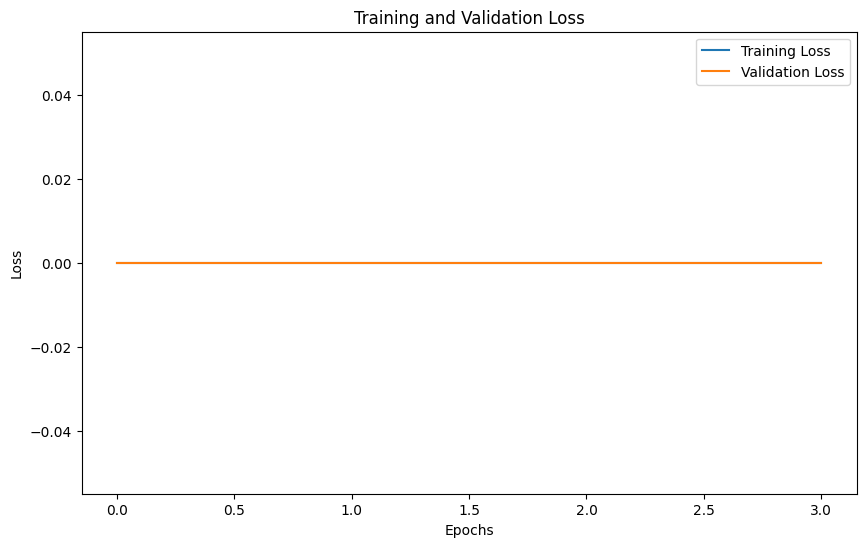

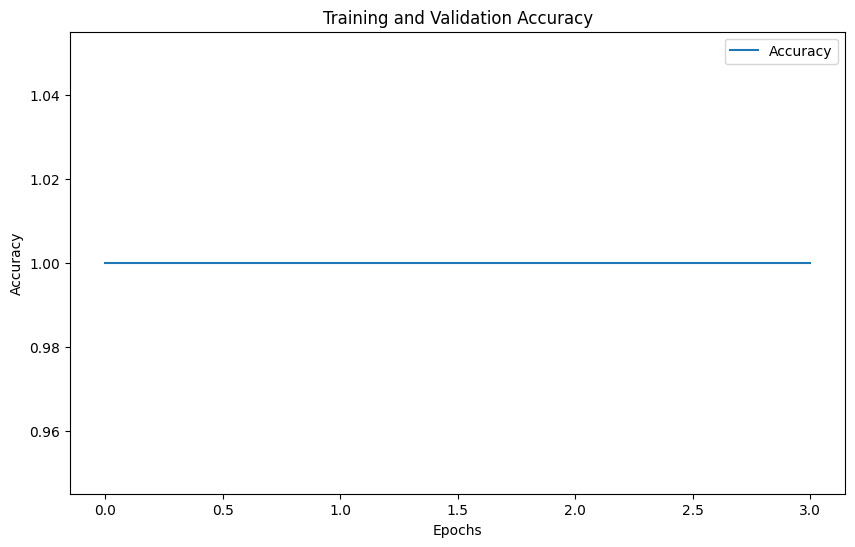

,text,category,category_
0,"xxbos xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy ,",0,0
1,xxbos i have a gtx 1070 t that i had before xxunk with an i5 7500 thinking it was enough to play xxunk i had to xxunk when i made xxunk with this processor 7500 did bottleneck a little more than once for example on code xxunk i got between 90 and 120 fps since i placed the 9600k i am almost always on 144 fps while war zone does n't fall under 120 on rainbow six even better all the way down under 144 fps is almost like having changed even video card and it 's fantastic,0,0
2,xxbos xxmaj your many new i9 i7 port xxunk board anything lga 1200 slot waste newest new guy get your own gon on xxunk capacity get 10th get save money your gon on need new board water cool thing xxmaj gen 4 nvme drive new 30 xxunk reason use xxunk 4 pcie slot here xxunk good starting point getting cpu step 1 get 11th xxmaj gen processor i9 budget step 2 get parentboard gen 4 pcie slot xxunk go step 3 obviously cool beauty reason would get 53ghz done safely cursor xxunk xxmaj xxunk,0,0
3,xxbos enough power play game single one xxunk us 50 cpu play gta 5 satisfaction far cry 6 city skyline even play xxunk 2 4 xxunk xxunk against their hit 100 benchmark i3 think xxunk 12th ge i3 powerful i7 generation buy i5 i7 enough update xxunk processor still going strong still game modern run his xxunk like field never xxunk 100 xxunk found 2 game stroke run star xxunk xxunk zone xxmaj xxunk 100 entire xxwrep 3 time xxmaj xxunk zone xxunk still run 80fps extra setting 4k star city bad,0,0
4,"xxbos xxmaj for the first time i have to say that delivery really fixed went term for the next week was xxunk but then xxunk were already released i thought i could only xxunk all the parts together and e can go together so i started to pack everything right up there and then the cpu was xxunk why the packaging was already on , but i did n't go any further i made the packaging where the cpu should now be up and saw a height of no great thought i",0,0
5,xxbos phenomenon upgrading i5 12400f best cpu pro xxunk spec rtx 4070ti z790 ddr5 gigabyte mobo 32 gb xxmaj xxunk ram 1 tb wd black ssd gene 4 per core noticeable fast area like xxunk application triple gpu xxunk game get noticeable fps boost xxunk talking xxunk cpu body game emulator get much better stability cpu use xxunk with looking energy efficiency 13th gen higher chip core mean power draw surre triple game chip using 2030 watt electricity emulator like xxunk near double went 30 40 watt average average 80 instance,0,0
6,xxbos xxunk the product that came to me for the first time if such a cpu was xxunk with an xxunk above with intellectual writing i5 9600k and with fake xxunk xxunk xxunk the motherboard mobile card talking to the xxunk there are no cpus with top xxunk made xxunk xxunk and they thought it was a trick although the xxunk product was fake but it managed to close my eye thanks to its media performance by making 60 fps on games as strong only with the gpu,0,0
7,xxbos xxmaj no doubt this processor when being a series k gives more xxunk than overclock in question games has enough performance to play in a media range you need to have a very powerful processor to play 4k in that case you need to invest more in a more powerful graphics card something necessary to know and that it is mentioned that it has a turbo frequency of 46 gz but this and maximum frequency per single xxunk could xxunk this frequency with a little overclock for,0,0
8,xxbos 

In [23]:
import matplotlib.pyplot as plt

train_losses = [val[0] for val in learn.recorder.values]
valid_losses = [val[1] for val in learn.recorder.values]
accuracies = [val[2] for val in learn.recorder.values]
epochs = range(len(train_losses))

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracies, label='Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

learn.show_results()


### Conclusion

This ULMFiT-based sentiment analysis of Intel product reviews provides valuable insights into customer perceptions and areas for improvement. By addressing the feedback, Intel can enhance customer satisfaction and product quality.
